<a href="https://colab.research.google.com/github/garyhyx/extra_images/blob/master/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from PIL import Image

In [2]:
!nvidia-smi # check GPU type. Tests are based on T4

Mon Sep 28 08:37:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:

!git clone https://github.com/garyhyx/extra_images.git #extra images mat file 

fatal: destination path 'extra_images' already exists and is not an empty directory.


In [5]:
ls

data/  extra_images/  fake_images_added.pkl  sample_data/


In [6]:
import torch
from PIL import Image
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF
import scipy.io as sio
# Tensor transform, will use to transform data to Tensor datatype
transform = transforms.ToTensor()

# SVHN training datasets - built into PyTorch "datasets" library
svhn_train = datasets.SVHN(root='data/', split='train', download=True, transform=transform)
        
SVHN = sio.loadmat('data/train_32x32.mat')['X'] #load from the downloaded dataset, images only, no lable needed for Gans
print(SVHN.data)
SVHN =np.transpose(SVHN, (3, 2, 0, 1)) # transpose the data since it is imported from mat file.
extra = sio.loadmat('extra_images/extra.mat')['A'] # load extra_files 
extra=np.transpose(extra, (3, 2, 0, 1))#transpose the data

new_set=np.concatenate((SVHN,extra),axis=0)  # combine two data
new_set_1=new_set.astype('float32') # copy the data_set and set to float, ready for transform data to Tensor datatype

for ii in range(len(new_set)):
  new_set_1[ii]=transform(np.transpose(new_set[ii], (1, 2, 0))) #transform the entire data_set to 0-1, 


batch_size = 128
num_workers = 0 # create DataLoaders for SVHN dataset - help batch data into batches of specific size

#new_set_1 is the new data set with SVHN dataset and 50 images
train_loader = torch.utils.data.DataLoader(dataset=new_set_1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers
                                           )



print("SVHN.shape:",SVHN.shape)
print("new_set.shape:",new_set_1.shape)  # check if 50 images are added 

Using downloaded and verified file: data/train_32x32.mat
SVHN.shape: (73257, 3, 32, 32)
new_set.shape: (73307, 3, 32, 32)


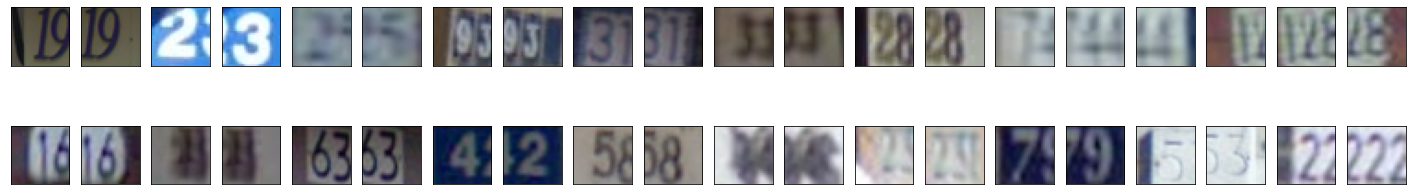

In [7]:
# take one batch of training images and check if add extra images succssed 

None_added_set = torch.utils.data.DataLoader(dataset=svhn_train, batch_size=128,
                                        shuffle=False,
                                        num_workers=num_workers
                                            )



Added_set = torch.utils.data.DataLoader(dataset=new_set_1, batch_size=128,
                                        shuffle=False,
                                        num_workers=num_workers
                                            )



dataiter = iter(None_added_set)
dataiter_1 = iter(Added_set)


no_extra_images,_= dataiter.next()
with_extra_images= dataiter_1.next()

fig = plt.figure(figsize=(25, 4))
plot_size=40

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(with_extra_images[idx], (1, 2, 0)))

#     # print out the correct label for each image
#     # .item() gets the value contained in a Tensor

    
# Note that we are working with 1 number that is (usually) most central to the image, 
# even if there are more numbers in the image it is labled as a single number   
# Check out image with 102 in it, it is labeled as 1...

In [8]:

img = no_extra_images[1]# None added set
images_1=with_extra_images[1] # added set


# check their max and min tensor value , they should be the same.
print('No_extra_images_Min: ', img.min())
print('No_extra_images_max: ', img.max())
print('With_extra_images_Min: ', images_1.min())
print('With_extra_images_Max: ', images_1.max())

No_extra_images_Min:  tensor(0.0627)
No_extra_images_max:  tensor(0.4431)
With_extra_images_Min:  tensor(0.0627)
With_extra_images_Max:  tensor(0.4431)


In [9]:

# The output of our G will be tanh activated e.i. on a range from [-1 1], 
# We need to rescale training images to that range. (Currently: [0 1])
def scale(xx, feature_range=(-1, 1)):
    ''' INPUT: image xx scaled to [0 1]
       OUTPUT: image scaled [-1 1] '''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    xx = xx * (max - min) + min
    return xx

In [10]:

# scale image
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.8745)
Scaled max:  tensor(-0.1137)


In [11]:
import torch.nn as nn
import torch.nn.functional as F

# Each layer should be convolution -> batch norm (optional) -> leaky ReLU
# conv function will put these layers together sequentialy.
# Use PyTorch's Sequential container which takes in a list of layers and creates 
# layers according to the order that they are passed in to the Sequential constructor.
# A strided convolutional layer and an optional batch norm layer
#
# https://pytorch.org/docs/stable/nn.html#batchnorm2d
# https://pytorch.org/docs/stable/nn.html#sequential
#
# We will use kernel_size = 4 & stride = 2, will reduce size of image by 2
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    # bias is set to False, so the layers are not offset by any amount
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:

# Use batch normalization with nn.BatchNorm2d on each layer except 
# the 1st convolutional layer and final linear output layer.
# In the DCGAN paper, they did all the downsampling using only strided 
# convolutional layers with no maxpooling layers

class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input, 16x16 output
        # self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 1st layer, no batch_norm 
        self.conv1 = conv(3, conv_dim, 4, batch_norm=True) # set First layer as True
        self.conv2 = conv(conv_dim, conv_dim*2, 4)   # 8x8 output
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # 4x4 output
        
        # final fully-connected layer - produces 1 output (par 2)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, xx):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(xx),  0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out

In [13]:
# define a function that will allow us to do:
# transpose convolution -> batch norm (optional: T/F) -> ReLU
# Use kernel_size 4 & stride 2 for transpose convolutions

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Create a transposed-convolutional layer with optional batch normalization """
    # create a sequence of transpose + optional batch norm layers
    layers = [] # empty list of layers
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [14]:
# In G 1st layer is a fully connected layer which is reshaped into a deep and narrow layer, eg. 4x4x512
# Then use batch norm & leaky ReLU activation
# Next is a series of transpose convolutional layers where you typically halve the depth 
# and double the width and height of the previous layer
# Apply batch normalization and ReLU to all but the last hidden layer. Where we apply a tanh activation

# Input: randomly generated vector z
# Output tanh values of size 32x32 which is the size of the SVHN images

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first fully-connected layer, 
        # params: latent verctor z & produces a layer 4x4x128
        #         4x4 part defined in the forward step below
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers, kernel_size = 4,
        # desired depth for RGB image is 3
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        # self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=True) # set the batch_norm for the last layer as True  (Q3)
    def forward(self, xx):
        # fully-connected + reshape 
        out = self.fc(xx)
        # params: batch_size, depth, 4, 4
        # -1 is a place holder for batch size
        # 128 - depth as defined by the convolutional dimention
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

In [15]:
conv_dim = 32
z_size = 100

# instantiate D and G
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(

In [16]:

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU...')

GPU available for training. Models moved to GPU


In [17]:

# Define Losses
# For D the total loss is the sum of the losses for real and fake images:
#     d_loss = d_real_loss + d_fake_loss
# The losses will by binary cross entropy loss with logits (BCEWithLogitsLoss). 
# BCEWithLogitsLoss combines a sigmoid activation function and a binary cross entropy loss
# We want D to output 1 for real images and 0 for fake images, make sure the losses to reflect that.
#
# For real images we want D(real_images) = 1, i.e. classify real images as = 1. 
# D's loss for the fake data is D(fake_images) = 0, where fake images are G's output, fake_images = G(z).
#
# For G the loss is similar but with labels flipped. G's goal is to get D(fake_images) = 1. 
# In this case, the labels are flipped to represent that the generator is trying to fool the discriminator 
# into thinking that the fake images it generates are real


def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

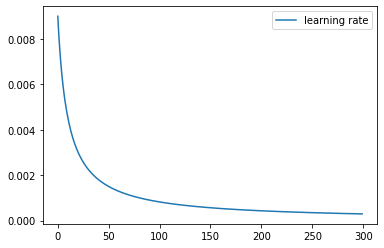

In [18]:
# learning rate decay
from matplotlib import pyplot

def	decay_lrate(initial_lrate, decay, iteration):
	return initial_lrate * (1.0 / (1.0 + decay * iteration))
 
#decays = [1E-1, 1E-2, 1E-3, 1E-4]
decays = [0.1]
lrate = 0.009
n_updates =300
for decay in decays:
	# calculate learning rates for updates
	lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
	# plot result
	pyplot.plot(lrates, label='learning rate')
pyplot.legend()
pyplot.show()

In [19]:
# Optimisers, similar to what we did before

import torch.optim as optim

# # params suggested to be good in the DCGAN paper 
# # GANs can be very seinsitive to small changes in parameter values
# # Check out some options in the DCGAN paper:
# #    https://arxiv.org/pdf/1511.06434.pdf
lr = 0.0002
beta1=0.5
beta2=0.999 # default value



# # Create optimizers for the discriminator and generator
# d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
# g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [20]:
# Discriminator training
#   Compute the discriminator loss on real, training images
#   Generate fake images
#   Compute the discriminator loss on fake, generated images
#   Add up real and fake loss
#   Perform backpropagation + an optimization step to update the discriminator's weights
#
# Generator training
#   Generate fake images
#   Compute the discriminator loss on fake images, using flipped labels!
#   Perform backpropagation + an optimization step to update the generator's weights

import torch.optim as optim
import time
import pickle as pkl # to save intermediate fake images

# training hyperparams
num_epochs = 50 # will run Training Time spend: 3416.2207777500153 s with T4 GPU

# keep track of loss and fake samples
samples = []
losses = []
print_every = 300



decay = 0.1
lrate = 0.009
beta1=0.5
beta2=0.999 # default value


start = time.time()
print("Start")

# Get some fixed data for evaluating the model's performance as we train
# Keep these images constant
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()


# train the network
for epoch in range(num_epochs):
 
    
    for batch_i, (real_images) in enumerate(train_loader):

                
        batch_size = real_images.size(0)




        # Create optimizers for the discriminator and generator
        d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
        g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
        
        # important rescaling step
        real_images = scale(real_images)

        lr=lrate * (1.0 / (1.0 + decay * epoch)) # decay learning rate
        #lr=0.0002 #fix reate
  
    
        
        
        # train D
        d_optimizer.zero_grad()
        
        # 1. Train with real images
        # Compute the D losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        # Generate fake images
        zz = np.random.uniform(-1, 1, size=(batch_size, z_size))
        zz = torch.from_numpy(zz).float()
        # move to GPU, if available
        if train_on_gpu:
            zz = zz.cuda()
        fake_images = G(zz)
        
        # Compute the D losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # train G
       
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels 
        # Generate fake images
        zz = np.random.uniform(-1, 1, size=(batch_size, z_size))
        zz = torch.from_numpy(zz).float()
        if train_on_gpu:
            zz = zz.cuda()
        fake_images = G(zz)
        
        # Compute the D losses on fake images 
        # using flipped labels
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append D loss and G loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}| lr: {:6.6f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item(),lr))  # added lr as learning rate

    
    # AFTER EACH EPOCH    
    # generate and save fake images
    G.eval() # eval mode for generating samples
    # eval mode - batch_norm & drop out behave differently in generating new samples
    # batch_norm should use population statistics instead of batch statistics in eval
    # dropout should not drop any nodes during testing
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # switch back to training mode

# Save training generator samples
end = time.time()
print("Training Time spend:",end - start,"s")
with open('fake_images_added.pkl', 'wb') as f:
    pkl.dump(samples, f)

Start
Epoch [    1/   50] | d_loss: 1.5090 | g_loss: 0.9104| lr: 0.000200


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 0.3261 | g_loss: 2.0530| lr: 0.000200
Epoch [    2/   50] | d_loss: 0.3289 | g_loss: 4.1868| lr: 0.000200
Epoch [    2/   50] | d_loss: 0.7820 | g_loss: 2.5795| lr: 0.000200
Epoch [    3/   50] | d_loss: 0.6283 | g_loss: 0.9568| lr: 0.000200
Epoch [    3/   50] | d_loss: 0.9042 | g_loss: 0.5988| lr: 0.000200
Epoch [    4/   50] | d_loss: 0.6444 | g_loss: 0.7067| lr: 0.000200
Epoch [    4/   50] | d_loss: 0.5527 | g_loss: 0.9581| lr: 0.000200
Epoch [    5/   50] | d_loss: 1.0893 | g_loss: 2.3845| lr: 0.000200
Epoch [    5/   50] | d_loss: 0.8136 | g_loss: 0.9956| lr: 0.000200
Epoch [    6/   50] | d_loss: 0.3087 | g_loss: 4.2557| lr: 0.000200
Epoch [    6/   50] | d_loss: 0.3942 | g_loss: 4.1406| lr: 0.000200
Epoch [    7/   50] | d_loss: 0.5335 | g_loss: 1.8101| lr: 0.000200
Epoch [    7/   50] | d_loss: 0.5074 | g_loss: 1.1913| lr: 0.000200
Epoch [    8/   50] | d_loss: 0.3984 | g_loss: 1.6183| lr: 0.000200
Epoch [    8/   50] | d_loss: 0.4380 | g_loss: 1

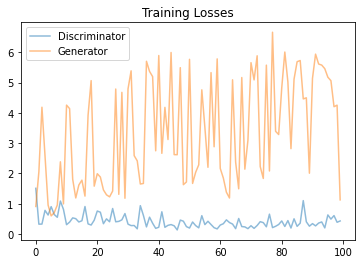

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [22]:

# Take a look at osme fake images generated during traning

# helper function for viewing a list of images, for us they are intermediate fake images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

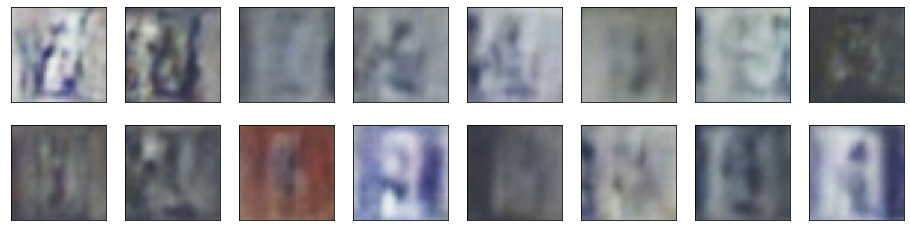

In [23]:
_ = view_samples(-1, samples)
